In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
import lightgbm as lgbm
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import pickle
import re
import os

In [13]:
df = pd.read_csv(os.path.join(os.path.pardir, "data", "laptop_price.csv"), encoding_errors = "ignore")
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [14]:
# drop first inches and id
df.drop(["Inches", "laptop_ID"], axis = 1, inplace = True)

In [15]:
X = df.drop("Price_euros", axis = 1).columns
y = "Price_euros"

In [23]:
def handle_storage_space(x):
    spaces_lst = []
    for val in x.split():
        if "GB" in val or "TB" in val:
            if "TB" in val:
                spaces_lst.append(int(re.findall("\d+", val)[0])*1000)
            else:
                spaces_lst.append(int(re.findall("\d+", val)[0]))
    return sum(spaces_lst)

In [24]:
# data cleaning & preprocessing phase..
df["Ram"] = df["Ram"].apply(lambda x: x[:-2])
df["Ram"] = df["Ram"].astype("int8")
df["Weight"] = df["Weight"].apply(lambda x: x[:-2])
df["Weight"] = df["Weight"].astype("float16")
df["CPU_manufacturer"] = df["Cpu"].apply(lambda x: x.split()[0])
df["CPU_frequency"] = df["Cpu"].apply(lambda x: x.split()[-1])
df["CPU_frequency"] = df["CPU_frequency"].apply(lambda x: x[:-3])
df["CPU_frequency"] = df["CPU_frequency"].astype("float16")
df["CPU_model"] = df["Cpu"].apply(lambda x: x.split()[1:-1])
df["CPU_model"] = df["CPU_model"].apply(lambda x:''.join(val+'-' if idx != len(x)-1 else val for idx, val in enumerate(x)))
width_lst = df["ScreenResolution"].apply(lambda x:int(x.split()[-1].split(sep = "x")[0]) * 0.0264583333).values 
height_lst = df["ScreenResolution"].apply(lambda x:int(x.split()[-1].split(sep = "x")[1]) * 0.0264583333).values
df["screen_area_cm2"] = list(map(lambda x, y: x*y, width_lst, height_lst))
df["is_4K"] = df["ScreenResolution"].apply(lambda x: 1 if "4K Ultra HD" in x else 0)
df["is_touchscreen"] = df["ScreenResolution"].apply(lambda x: 1 if "Touchscreen" in x else 0)
df["is_full_HD"] = df["ScreenResolution"].apply(lambda x: 1 if "Full HD" in x else 0)
df["is_Quad"] = df["ScreenResolution"].apply(lambda x: 1 if "Quad" in x else 0)
df["is_HD+"] = df["ScreenResolution"].apply(lambda x: 1 if "HD+" in x else 0)
df["is_ips_panel"] = df["ScreenResolution"].apply(lambda x: 1 if "IPS Panel" in x else 0)
df["is_retina_display"] = df["ScreenResolution"].apply(lambda x: 1 if "Retina Display" in x else 0)
df["is_ssd"] = df["Memory"].apply(lambda x: 1 if "SSD" in x else 0)
df["is_hdd"] = df["Memory"].apply(lambda x: 1 if "HDD" in x else 0)
df["is_hybrid_storage"] = df["Memory"].apply(lambda x: 1 if "Hybrid" in x else 0)
df["is_flash_storage"] = df["Memory"].apply(lambda x: 1 if "Flash" in x else 0)
df["unique_storage_types"] = df["is_ssd"] + df["is_hdd"] + df["is_hybrid_storage"] + df["is_flash_storage"]
df["total_storage"] = df["Memory"].apply(handle_storage_space)
df["GPU_manufacturer"] = df["Gpu"].apply(lambda x:x.split()[0])
# Drop Raw Data Columns....
df.drop(["ScreenResolution", "Cpu", "Memory", "Gpu"], axis = 1, inplace = True)

In [35]:
df.drop("Product", axis = 1, inplace = True)

In [38]:
company_enc = OrdinalEncoder()
type_enc = OrdinalEncoder()
os_enc = OrdinalEncoder()
cpu_manfacturer_enc = OrdinalEncoder()
cpu_model_enc = OrdinalEncoder()
gpu_manfacturer_enc = OrdinalEncoder()

In [36]:
# copy the dataframe.
pre_df = df.copy()

In [39]:
pre_df["Company"] = company_enc.set_params(encoded_missing_value=-1).fit_transform(pre_df["Company"].values.reshape(-1, 1))
pre_df["TypeName"] = company_enc.set_params(encoded_missing_value=-1).fit_transform(pre_df["TypeName"].values.reshape(-1, 1))
pre_df["OpSys"] = company_enc.set_params(encoded_missing_value=-1).fit_transform(pre_df["OpSys"].values.reshape(-1, 1))
pre_df["CPU_manufacturer"] = company_enc.set_params(encoded_missing_value=-1).fit_transform(pre_df["CPU_manufacturer"].values.reshape(-1, 1))
pre_df["CPU_model"] = company_enc.set_params(encoded_missing_value=-1).fit_transform(pre_df["CPU_model"].values.reshape(-1, 1))
pre_df["GPU_manufacturer"] = company_enc.set_params(encoded_missing_value=-1).fit_transform(pre_df["GPU_manufacturer"].values.reshape(-1, 1))

In [46]:
# categorical columns: Company:0, TypeName:1, OpSys:3, CPU_manufacturer:6, CPU_model:8, 
# is_4K':10, 'is_touchscreen':11, 'is_full_HD':12, 'is_Quad':13, 'is_HD+':14,
#'is_ips_panel':15, 'is_retina_display':16, 'is_ssd':17, 'is_hdd':18,
#'is_hybrid_storage':19, 'is_flash_storage':20, 'unique_storage_types:21, GPU_manufacturer:23
cat_idx = [0, 1, 3, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22]

In [47]:
X = pre_df.drop("Price_euros", axis = 1)
y = pre_df["Price_euros"]
mi_scores = mutual_info_regression(X, y, discrete_features=cat_idx)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, 'Company'),
  Text(1, 0, 'TypeName'),
  Text(2, 0, 'Ram'),
  Text(3, 0, 'OpSys'),
  Text(4, 0, 'Weight'),
  Text(5, 0, 'CPU_manufacturer'),
  Text(6, 0, 'CPU_frequency'),
  Text(7, 0, 'CPU_model'),
  Text(8, 0, 'screen_area_cm2'),
  Text(9, 0, 'is_4K'),
  Text(10, 0, 'is_touchscreen'),
  Text(11, 0, 'is_full_HD'),
  Text(12, 0, 'is_Quad'),
  Text(13, 0, 'is_HD+'),
  Text(14, 0, 'is_ips_panel'),
  Text(15, 0, 'is_retina_display'),
  Text(16, 0, 'is_ssd'),
  Text(17, 0, 'is_hdd'),
  Text(18, 0, 'is_hybrid_storage'),
  Text(19, 0, 'is_flash_storage'),
  Text(20, 0, 'unique_storage_types'),
  Text(21, 0, 'total_storage'),
  Text(22, 0, 'GPU_manufacturer')])

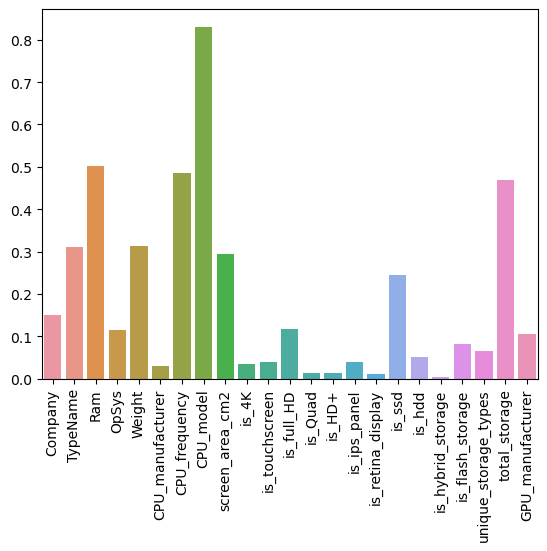

In [53]:
# Mutual Information Score for each feature...
sns.barplot(x = X.columns, y = mi_scores)
plt.xticks(rotation = 90)

In [60]:
# search space of lightgbm regressor
SEARCH_SPACE={
    "n_estimators":scope.int(hp.quniform("n_estimators", 20, 700, 5)),
    "max_depth":scope.int(hp.quniform("max_depth", 1, 12, 1)),
    "num_leaves":scope.int(hp.quniform("num_leaves", 20, 100, 5)),
    "min_data_in_leaf":scope.int(hp.quniform("min_data_in_leaf", 100, 500, 50)),
    "min_gain_to_split":scope.float(hp.quniform("min_gain_to_split", 0.1, 15.0, 0.4)),
    "learning_rate":scope.float(hp.quniform("learning_rate", 0.01, 0.3, 0.001)),
    "lambda_l2":hp.loguniform("reg_alpha", -5, -1),
    "lambda_l1":hp.loguniform("reg_lambda", -6, -1),
    "objective":"regression",
    "seed":42,
    "categorical_feature":cat_idx
}

In [56]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [61]:
def optimize(params):
    booster = lgbm.LGBMRegressor(**params)
    booster.fit(X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric = "rmse",
                early_stopping_rounds = 20)
    y_pred = booster.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    return {"loss":rmse, "status":STATUS_OK}

In [62]:
best_res = fmin(
    fn = optimize,
    space = SEARCH_SPACE,
    algo = tpe.suggest,
    max_evals=25,
    trials=Trials()
)

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=1.2000000000000002, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.2000000000000002
[LightGBM] [Warning] lambda_l1 is set=0.002817592184209744, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002817592184209744
[LightGBM] [Warning] lambda_l2 is set=0.02146805361476941, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02146805361476941
  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[1]	valid_0's rmse: 697.901	valid_0's l2: 487066      
[2]	valid_0's rmse: 660.187	valid_0's l2: 435846      
[3]	valid_0's rmse: 636.492	valid_0's l2: 405122      
[4]	valid_0's rmse: 608.838	valid_0's l2: 370684      
[5]	valid_0's rmse: 591.229	valid_0's l2: 349552      
[6]	valid_0's rmse: 580.241	valid_0's l2: 336679      
[7]	valid_0's rmse: 568.704	valid_0's l2: 323424      
[8]	valid_0's rmse: 565.737	valid_0's l2: 320058      
[9]	valid_0's rmse: 557.019	valid_0's l2: 310270      
[10]	valid_0's rmse: 553.533	valid_0's l2: 306399     
[11]	valid_0's rmse: 550.205	valid_0's l2: 302726     
[12]	valid_0's rmse: 548.444	valid_0's l2: 300791     
[13]	valid_0's rmse: 546.054	valid_0's l2: 298175     
[14]	valid_0's rmse: 544.958	valid_0's l2: 296979     
[15]	valid_0's rmse: 540.514	valid_0's l2: 292155     
[16]	valid_0's rmse: 538.637	valid_0's l2: 290129     
[17]	valid_0's rmse: 536.386	valid_0's l2: 287710     
[18]	valid_0's rmse: 536.454	valid_0's l2: 287783     
[19]	valid

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[2]	valid_0's rmse: 707.766	valid_0's l2: 500933                               
[3]	valid_0's rmse: 692.484	valid_0's l2: 479534                               
[4]	valid_0's rmse: 681.732	valid_0's l2: 464758                               
[5]	valid_0's rmse: 676.204	valid_0's l2: 457251                               
[6]	valid_0's rmse: 664.654	valid_0's l2: 441765                               
[7]	valid_0's rmse: 658.524	valid_0's l2: 433654                               
[8]	valid_0's rmse: 656.069	valid_0's l2: 430426                               
[9]	valid_0's rmse: 648.701	valid_0's l2: 420813                               
[10]	valid_0's rmse: 645.348	valid_0's l2: 416474                              
[11]	valid_0's rmse: 644.123	valid_0's l2: 414894                              
[12]	valid_0's rmse: 639.339	valid_0's l2: 408754                              
[13]	valid_0's rmse: 637.581	valid_0's l2: 406510                              
[14]	valid_0's rmse: 637.284	valid_0's l

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[2]	valid_0's rmse: 600.806	valid_0's l2: 360968                               
[3]	valid_0's rmse: 560.011	valid_0's l2: 313613                               
[4]	valid_0's rmse: 531.014	valid_0's l2: 281976                               
[5]	valid_0's rmse: 511.176	valid_0's l2: 261301                               
[6]	valid_0's rmse: 501.869	valid_0's l2: 251873                               
[7]	valid_0's rmse: 495.422	valid_0's l2: 245442                               
[8]	valid_0's rmse: 491.939	valid_0's l2: 242004                               
[9]	valid_0's rmse: 489.515	valid_0's l2: 239625                               
[10]	valid_0's rmse: 484.343	valid_0's l2: 234588                              
[11]	valid_0's rmse: 477.622	valid_0's l2: 228123                              
[12]	valid_0's rmse: 474.239	valid_0's l2: 224902                              
[13]	valid_0's rmse: 472.359	valid_0's l2: 223123                              
[14]	valid_0's rmse: 468.304	valid_0's l

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[1]	valid_0's rmse: 689.793	valid_0's l2: 475814
[2]	valid_0's rmse: 646.448	valid_0's l2: 417895                                
[3]	valid_0's rmse: 610.576	valid_0's l2: 372803                                
[4]	valid_0's rmse: 586.737	valid_0's l2: 344260                                
[5]	valid_0's rmse: 566.801	valid_0's l2: 321263                                
[6]	valid_0's rmse: 551.537	valid_0's l2: 304193                                
[7]	valid_0's rmse: 539.242	valid_0's l2: 290782                                
[8]	valid_0's rmse: 531.169	valid_0's l2: 282141                                
[9]	valid_0's rmse: 524.764	valid_0's l2: 275377                                
[10]	valid_0's rmse: 519.652	valid_0's l2: 270038                               
[11]	valid_0's rmse: 514.421	valid_0's l2: 264629                               
[12]	valid_0's rmse: 513.256	valid_0's l2: 263432                               
[13]	valid_0's rmse: 507.965	valid_0's l2: 258029           

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[1]	valid_0's rmse: 727.05	valid_0's l2: 528602                                 
[2]	valid_0's rmse: 701.026	valid_0's l2: 491437                                
[3]	valid_0's rmse: 677.616	valid_0's l2: 459164                                
[4]	valid_0's rmse: 657.609	valid_0's l2: 432450                                
[5]	valid_0's rmse: 639.164	valid_0's l2: 408530                                
[6]	valid_0's rmse: 623.339	valid_0's l2: 388551                                
[7]	valid_0's rmse: 607.115	valid_0's l2: 368588                                
[8]	valid_0's rmse: 592.763	valid_0's l2: 351368                                
[9]	valid_0's rmse: 580.644	valid_0's l2: 337147                                
[10]	valid_0's rmse: 569.968	valid_0's l2: 324863                               
[11]	valid_0's rmse: 561.017	valid_0's l2: 314740                               
[12]	valid_0's rmse: 551.634	valid_0's l2: 304300                               
[13]	valid_0's rmse: 543.455

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[3]	valid_0's rmse: 646.6	valid_0's l2: 418092                                 
[4]	valid_0's rmse: 621.032	valid_0's l2: 385680                               
[5]	valid_0's rmse: 597.135	valid_0's l2: 356570                               
[6]	valid_0's rmse: 577.845	valid_0's l2: 333905                               
[7]	valid_0's rmse: 562.594	valid_0's l2: 316512                               
[8]	valid_0's rmse: 548.721	valid_0's l2: 301095                               
[9]	valid_0's rmse: 537.809	valid_0's l2: 289239                               
[10]	valid_0's rmse: 523.431	valid_0's l2: 273980                              
[11]	valid_0's rmse: 513.433	valid_0's l2: 263614                              
[12]	valid_0's rmse: 503.587	valid_0's l2: 253600                              
[13]	valid_0's rmse: 498.049	valid_0's l2: 248053                              
[14]	valid_0's rmse: 490.955	valid_0's l2: 241036                              
[15]	valid_0's rmse: 483.724	valid_0's l

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[4]	valid_0's rmse: 734.189	valid_0's l2: 539034
[5]	valid_0's rmse: 732.581	valid_0's l2: 536675                                
[6]	valid_0's rmse: 731.706	valid_0's l2: 535394                                
[7]	valid_0's rmse: 730.874	valid_0's l2: 534176                                
[8]	valid_0's rmse: 730.065	valid_0's l2: 532995                                
[9]	valid_0's rmse: 729.574	valid_0's l2: 532278                                
[10]	valid_0's rmse: 726.824	valid_0's l2: 528272                               
[11]	valid_0's rmse: 726.869	valid_0's l2: 528339                               
[12]	valid_0's rmse: 724.835	valid_0's l2: 525385                               
[13]	valid_0's rmse: 723.275	valid_0's l2: 523127                               
[14]	valid_0's rmse: 723.173	valid_0's l2: 522980                               
[15]	valid_0's rmse: 723.327	valid_0's l2: 523203                               
[16]	valid_0's rmse: 723.711	valid_0's l2: 523758           

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[5]	valid_0's rmse: 590.225	valid_0's l2: 348366                                
[6]	valid_0's rmse: 581.837	valid_0's l2: 338534                                
[7]	valid_0's rmse: 573.028	valid_0's l2: 328361                                
[8]	valid_0's rmse: 559.681	valid_0's l2: 313243                                
[9]	valid_0's rmse: 554.174	valid_0's l2: 307109                                
[10]	valid_0's rmse: 553.244	valid_0's l2: 306079                               
[11]	valid_0's rmse: 549.878	valid_0's l2: 302365                               
[12]	valid_0's rmse: 547.552	valid_0's l2: 299813                               
[13]	valid_0's rmse: 544.915	valid_0's l2: 296933                               
[14]	valid_0's rmse: 543.368	valid_0's l2: 295249                               
[15]	valid_0's rmse: 543.506	valid_0's l2: 295399                               
[16]	valid_0's rmse: 542.707	valid_0's l2: 294531                               
[17]	valid_0's rmse: 540.616

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[5]	valid_0's rmse: 694.977	valid_0's l2: 482993                                
[6]	valid_0's rmse: 684.481	valid_0's l2: 468514                                
[7]	valid_0's rmse: 676.218	valid_0's l2: 457271                                
[8]	valid_0's rmse: 667.358	valid_0's l2: 445367                                
[9]	valid_0's rmse: 658.857	valid_0's l2: 434093                                
[10]	valid_0's rmse: 651.427	valid_0's l2: 424357                               
[11]	valid_0's rmse: 643.273	valid_0's l2: 413800                               
[12]	valid_0's rmse: 635.936	valid_0's l2: 404415                               
[13]	valid_0's rmse: 630.297	valid_0's l2: 397275                               
[14]	valid_0's rmse: 623.448	valid_0's l2: 388688                               
[15]	valid_0's rmse: 618.009	valid_0's l2: 381935                               
[16]	valid_0's rmse: 612.346	valid_0's l2: 374967                               
[17]	valid_0's rmse: 606.086

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[3]	valid_0's rmse: 652.231	valid_0's l2: 425406                                
[4]	valid_0's rmse: 635.293	valid_0's l2: 403598                                
[5]	valid_0's rmse: 612.516	valid_0's l2: 375176                                
[6]	valid_0's rmse: 597.469	valid_0's l2: 356969                                
[7]	valid_0's rmse: 588.051	valid_0's l2: 345804                                
[8]	valid_0's rmse: 575.101	valid_0's l2: 330741                                
[9]	valid_0's rmse: 567.432	valid_0's l2: 321979                                
[10]	valid_0's rmse: 561.464	valid_0's l2: 315242                               
[11]	valid_0's rmse: 554.638	valid_0's l2: 307624                               
[12]	valid_0's rmse: 548.823	valid_0's l2: 301207                               
[13]	valid_0's rmse: 547.152	valid_0's l2: 299376                               
[14]	valid_0's rmse: 542.673	valid_0's l2: 294494                               
[15]	valid_0's rmse: 539.839

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[4]	valid_0's rmse: 628.573	valid_0's l2: 395104                                 
[5]	valid_0's rmse: 605.492	valid_0's l2: 366621                                 
[6]	valid_0's rmse: 590.773	valid_0's l2: 349013                                 
[7]	valid_0's rmse: 578.158	valid_0's l2: 334267                                 
[8]	valid_0's rmse: 565.568	valid_0's l2: 319867                                 
[9]	valid_0's rmse: 559.166	valid_0's l2: 312667                                 
[10]	valid_0's rmse: 551.761	valid_0's l2: 304440                                
[11]	valid_0's rmse: 545.609	valid_0's l2: 297689                                
[12]	valid_0's rmse: 545.041	valid_0's l2: 297070                                
[13]	valid_0's rmse: 541.268	valid_0's l2: 292971                                
[14]	valid_0's rmse: 537.07	valid_0's l2: 288444                                 
[15]	valid_0's rmse: 535.723	valid_0's l2: 286999                                
[16]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[8]	valid_0's rmse: 559.559	valid_0's l2: 313106                                 
[9]	valid_0's rmse: 549.474	valid_0's l2: 301922                                 
[10]	valid_0's rmse: 537.684	valid_0's l2: 289104                                
[11]	valid_0's rmse: 530.375	valid_0's l2: 281298                                
[12]	valid_0's rmse: 522.025	valid_0's l2: 272510                                
[13]	valid_0's rmse: 514.169	valid_0's l2: 264370                                
[14]	valid_0's rmse: 509.008	valid_0's l2: 259089                                
[15]	valid_0's rmse: 505.817	valid_0's l2: 255851                                
[16]	valid_0's rmse: 500.572	valid_0's l2: 250572                                
[17]	valid_0's rmse: 496.628	valid_0's l2: 246640                                
[18]	valid_0's rmse: 493.549	valid_0's l2: 243591                                
[19]	valid_0's rmse: 489.884	valid_0's l2: 239987                                
[20]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[10]	valid_0's rmse: 569.357	valid_0's l2: 324168                                
[11]	valid_0's rmse: 565.272	valid_0's l2: 319533                                
[12]	valid_0's rmse: 560.433	valid_0's l2: 314085                                
[13]	valid_0's rmse: 553.218	valid_0's l2: 306051                                
[14]	valid_0's rmse: 550.715	valid_0's l2: 303287                                
[15]	valid_0's rmse: 550.464	valid_0's l2: 303011                                
[16]	valid_0's rmse: 548.695	valid_0's l2: 301066                                
[17]	valid_0's rmse: 546.557	valid_0's l2: 298724                                
[18]	valid_0's rmse: 545.226	valid_0's l2: 297271                                
[19]	valid_0's rmse: 543.478	valid_0's l2: 295368                                
[20]	valid_0's rmse: 543.481	valid_0's l2: 295372                                
[21]	valid_0's rmse: 539.161	valid_0's l2: 290695                                
[22]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[5]	valid_0's rmse: 535.53	valid_0's l2: 286793                                  
[6]	valid_0's rmse: 517.902	valid_0's l2: 268223                                 
[7]	valid_0's rmse: 509.639	valid_0's l2: 259732                                 
[8]	valid_0's rmse: 501.132	valid_0's l2: 251134                                 
[9]	valid_0's rmse: 493.785	valid_0's l2: 243824                                 
[10]	valid_0's rmse: 487.926	valid_0's l2: 238071                                
[11]	valid_0's rmse: 482.83	valid_0's l2: 233125                                 
[12]	valid_0's rmse: 479.597	valid_0's l2: 230013                                
[13]	valid_0's rmse: 474.865	valid_0's l2: 225497                                
[14]	valid_0's rmse: 470.583	valid_0's l2: 221449                                
[15]	valid_0's rmse: 469.366	valid_0's l2: 220305                                
[16]	valid_0's rmse: 467.032	valid_0's l2: 218119                                
[17]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil


[6]	valid_0's rmse: 646.744	valid_0's l2: 418278                                 
[7]	valid_0's rmse: 638.946	valid_0's l2: 408252                                 
[8]	valid_0's rmse: 635.667	valid_0's l2: 404073                                 
[9]	valid_0's rmse: 635.466	valid_0's l2: 403816                                 
[10]	valid_0's rmse: 633.967	valid_0's l2: 401914                                
[11]	valid_0's rmse: 631.185	valid_0's l2: 398395                                
[12]	valid_0's rmse: 627.2	valid_0's l2: 393380                                  
[13]	valid_0's rmse: 617.57	valid_0's l2: 381392                                 
[14]	valid_0's rmse: 614.551	valid_0's l2: 377674                                
[15]	valid_0's rmse: 612.343	valid_0's l2: 374963                                
[16]	valid_0's rmse: 609.685	valid_0's l2: 371715                                
[17]	valid_0's rmse: 609.109	valid_0's l2: 371014                                
[18]	valid_0's 

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[8]	valid_0's rmse: 679.304	valid_0's l2: 461454                                 
[9]	valid_0's rmse: 670.705	valid_0's l2: 449845                                 
[10]	valid_0's rmse: 663.436	valid_0's l2: 440148                                
[11]	valid_0's rmse: 657.35	valid_0's l2: 432109                                 
[12]	valid_0's rmse: 650.141	valid_0's l2: 422684                                
[13]	valid_0's rmse: 644.186	valid_0's l2: 414976                                
[14]	valid_0's rmse: 639.331	valid_0's l2: 408745                                
[15]	valid_0's rmse: 635.075	valid_0's l2: 403320                                
[16]	valid_0's rmse: 629.273	valid_0's l2: 395985                                
[17]	valid_0's rmse: 624.68	valid_0's l2: 390225                                 
[18]	valid_0's rmse: 621.043	valid_0's l2: 385694                                
[19]	valid_0's rmse: 616.201	valid_0's l2: 379703                                
[20]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[4]	valid_0's rmse: 614.31	valid_0's l2: 377377                                  
[5]	valid_0's rmse: 592.568	valid_0's l2: 351136                                 
[6]	valid_0's rmse: 581.735	valid_0's l2: 338415                                 
[7]	valid_0's rmse: 573.784	valid_0's l2: 329228                                 
[8]	valid_0's rmse: 567.637	valid_0's l2: 322212                                 
[9]	valid_0's rmse: 557.387	valid_0's l2: 310681                                 
[10]	valid_0's rmse: 552.747	valid_0's l2: 305530                                
[11]	valid_0's rmse: 552.379	valid_0's l2: 305123                                
[12]	valid_0's rmse: 549.692	valid_0's l2: 302161                                
[13]	valid_0's rmse: 547.154	valid_0's l2: 299377                                
[14]	valid_0's rmse: 545.023	valid_0's l2: 297051                                
[15]	valid_0's rmse: 543.298	valid_0's l2: 295172                                
[16]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[1]	valid_0's rmse: 715.113	valid_0's l2: 511387                                 
[2]	valid_0's rmse: 688.746	valid_0's l2: 474371                                 
[3]	valid_0's rmse: 679.36	valid_0's l2: 461530                                  
[4]	valid_0's rmse: 667.237	valid_0's l2: 445205                                 
[5]	valid_0's rmse: 652.134	valid_0's l2: 425279                                 
[6]	valid_0's rmse: 649.559	valid_0's l2: 421926                                 


c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'



[7]	valid_0's rmse: 641.234	valid_0's l2: 411181
[8]	valid_0's rmse: 637.429	valid_0's l2: 406316                                 
[9]	valid_0's rmse: 637.04	valid_0's l2: 405819                                  
[10]	valid_0's rmse: 632.701	valid_0's l2: 400311                                
[11]	valid_0's rmse: 631.272	valid_0's l2: 398505                                
[12]	valid_0's rmse: 628.534	valid_0's l2: 395055                                
[13]	valid_0's rmse: 627.873	valid_0's l2: 394224                                
[14]	valid_0's rmse: 624.856	valid_0's l2: 390446                                
[15]	valid_0's rmse: 622.66	valid_0's l2: 387705                                 
[16]	valid_0's rmse: 616.511	valid_0's l2: 380086                                
[17]	valid_0's rmse: 613.626	valid_0's l2: 376537                                
[18]	valid_0's rmse: 613.08	valid_0's l2: 375867                                 
[19]	valid_0's rmse: 610.922	valid_0's l2: 373226

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[3]	valid_0's rmse: 724.664	valid_0's l2: 525137                                 
[4]	valid_0's rmse: 715.83	valid_0's l2: 512413                                  
[5]	valid_0's rmse: 707.113	valid_0's l2: 500009                                 
[6]	valid_0's rmse: 699.676	valid_0's l2: 489546                                 
[7]	valid_0's rmse: 692.193	valid_0's l2: 479131                                 
[8]	valid_0's rmse: 685.277	valid_0's l2: 469605                                 
[9]	valid_0's rmse: 679.384	valid_0's l2: 461563                                 
[10]	valid_0's rmse: 673.425	valid_0's l2: 453501                                
[11]	valid_0's rmse: 668.374	valid_0's l2: 446724                                
[12]	valid_0's rmse: 661.806	valid_0's l2: 437987                                
[13]	valid_0's rmse: 656.886	valid_0's l2: 431499                                
[14]	valid_0's rmse: 650.982	valid_0's l2: 423777                                
[15]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[7]	valid_0's rmse: 740.261	valid_0's l2: 547986                                 
[8]	valid_0's rmse: 738.777	valid_0's l2: 545792                                 
[9]	valid_0's rmse: 737.786	valid_0's l2: 544328                                 
[10]	valid_0's rmse: 736.465	valid_0's l2: 542381                                
[11]	valid_0's rmse: 735.712	valid_0's l2: 541272                                
[12]	valid_0's rmse: 734.91	valid_0's l2: 540092                                 
[13]	valid_0's rmse: 733.914	valid_0's l2: 538630                                
[14]	valid_0's rmse: 732.745	valid_0's l2: 536915                                
[15]	valid_0's rmse: 732.13	valid_0's l2: 536014                                 
[16]	valid_0's rmse: 731.662	valid_0's l2: 535329                                
[17]	valid_0's rmse: 730.939	valid_0's l2: 534272                                
[18]	valid_0's rmse: 730.503	valid_0's l2: 533634                                
[19]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[5]	valid_0's rmse: 608.192	valid_0's l2: 369897                                 
[6]	valid_0's rmse: 589.881	valid_0's l2: 347959                                 
[7]	valid_0's rmse: 574.293	valid_0's l2: 329813                                 
[8]	valid_0's rmse: 559.594	valid_0's l2: 313145                                 
[9]	valid_0's rmse: 549.02	valid_0's l2: 301423                                  
[10]	valid_0's rmse: 538.207	valid_0's l2: 289667                                
[11]	valid_0's rmse: 525.769	valid_0's l2: 276433                                
[12]	valid_0's rmse: 515.743	valid_0's l2: 265991                                
[13]	valid_0's rmse: 506.918	valid_0's l2: 256966                                
[14]	valid_0's rmse: 499.267	valid_0's l2: 249268                                
[15]	valid_0's rmse: 492.472	valid_0's l2: 242528                                
[16]	valid_0's rmse: 487.096	valid_0's l2: 237263                                
[17]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[7]	valid_0's rmse: 578.276	valid_0's l2: 334403
[8]	valid_0's rmse: 565.352	valid_0's l2: 319623                                 
[9]	valid_0's rmse: 552.926	valid_0's l2: 305727                                 
[10]	valid_0's rmse: 542.08	valid_0's l2: 293851                                 
[11]	valid_0's rmse: 530.325	valid_0's l2: 281245                                
[12]	valid_0's rmse: 519.472	valid_0's l2: 269851                                
[13]	valid_0's rmse: 511.301	valid_0's l2: 261428                                
[14]	valid_0's rmse: 502.833	valid_0's l2: 252841                                
[15]	valid_0's rmse: 495.929	valid_0's l2: 245946                                
[16]	valid_0's rmse: 489.269	valid_0's l2: 239384                                
[17]	valid_0's rmse: 483.041	valid_0's l2: 233329                                
[18]	valid_0's rmse: 478.588	valid_0's l2: 229047                                
[19]	valid_0's rmse: 473.67	valid_0's l2: 224363 

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[4]	valid_0's rmse: 733.265	valid_0's l2: 537678
[5]	valid_0's rmse: 728.035	valid_0's l2: 530034                                 
[6]	valid_0's rmse: 722.949	valid_0's l2: 522655                                 
[7]	valid_0's rmse: 718.003	valid_0's l2: 515529                                 
[8]	valid_0's rmse: 713.512	valid_0's l2: 509099                                 
[9]	valid_0's rmse: 709.15	valid_0's l2: 502893                                  
[10]	valid_0's rmse: 704.542	valid_0's l2: 496379                                
[11]	valid_0's rmse: 700.063	valid_0's l2: 490088                                
[12]	valid_0's rmse: 695.711	valid_0's l2: 484013                                
[13]	valid_0's rmse: 691.758	valid_0's l2: 478529                                
[14]	valid_0's rmse: 687.592	valid_0's l2: 472783                                
[15]	valid_0's rmse: 683.564	valid_0's l2: 467259                                
[16]	valid_0's rmse: 679.889	valid_0's l2: 462249

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[1]	valid_0's rmse: 697.239	valid_0's l2: 486143                                 
[2]	valid_0's rmse: 650.27	valid_0's l2: 422851                                  
[3]	valid_0's rmse: 615.594	valid_0's l2: 378956                                 
[4]	valid_0's rmse: 584.328	valid_0's l2: 341439                                 
[5]	valid_0's rmse: 562.086	valid_0's l2: 315941                                 
[6]	valid_0's rmse: 543.119	valid_0's l2: 294978                                 
[7]	valid_0's rmse: 522.313	valid_0's l2: 272811                                 
[8]	valid_0's rmse: 508.409	valid_0's l2: 258480                                 
[9]	valid_0's rmse: 498.426	valid_0's l2: 248429                                 
[10]	valid_0's rmse: 488.121	valid_0's l2: 238262                                
[11]	valid_0's rmse: 480.158	valid_0's l2: 230552                                
[12]	valid_0's rmse: 471.827	valid_0's l2: 222621                                
[13]	valid_0's r

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'

c:\Users\hp\anaconda3\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and wil

[3]	valid_0's rmse: 618.063	valid_0's l2: 382002
[4]	valid_0's rmse: 589.9	valid_0's l2: 347982                                   
[5]	valid_0's rmse: 565.055	valid_0's l2: 319287                                 
[6]	valid_0's rmse: 548.856	valid_0's l2: 301243                                 
[7]	valid_0's rmse: 532.481	valid_0's l2: 283536                                 
[8]	valid_0's rmse: 522.482	valid_0's l2: 272987                                 
[9]	valid_0's rmse: 512.576	valid_0's l2: 262734                                 
[10]	valid_0's rmse: 503.244	valid_0's l2: 253255                                
[11]	valid_0's rmse: 499.149	valid_0's l2: 249150                                
[12]	valid_0's rmse: 494.861	valid_0's l2: 244887                                
[13]	valid_0's rmse: 490.419	valid_0's l2: 240511                                
[14]	valid_0's rmse: 485.096	valid_0's l2: 235318                                
[15]	valid_0's rmse: 482.998	valid_0's l2: 233287

In [64]:
params = {'learning_rate': 0.10400000000000001,
 'max_depth': 8,
 'min_data_in_leaf': 100,
 'min_gain_to_split': 14.8,
 'n_estimators': 655,
 'num_leaves': 100,
 'reg_alpha': 0.07196297238370417,
 'reg_lambda': 0.08567390652730536}

In [74]:
cat_preprocessor = Pipeline(steps = [
    ("ordinal-enc", OrdinalEncoder(encoded_missing_value=-1))
])
preprocessor = ColumnTransformer(transformers = [
    ("cat", cat_preprocessor, cat_idx),
    ("other", "passthrough", [2, 4, 6, 8, 21])
])
model_pipeline = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("missing_handler", SimpleImputer(strategy='constant', fill_value=-1)),
    ("lgbm", lgbm.LGBMRegressor(**params))
])

In [75]:
X = df.drop("Price_euros", axis = 1)
y = df["Price_euros"]

In [76]:
model_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('ordinal-enc',
                                                                   OrdinalEncoder(encoded_missing_value=-1))]),
                                                  [0, 1, 3, 5, 7, 9, 10, 11, 12,
                                                   13, 14, 15, 16, 17, 18, 19,
                                                   20, 22]),
                                                 ('other', 'passthrough',
                                                  [2, 4, 6, 8, 21])])),
                ('missing_handler',
                 SimpleImputer(fill_value=-1, strategy='constant')),
                ('lgbm',
                 LGBMRegressor(learning_rate=0.10400000000000001, max_depth=8,
                               min_data_in_leaf=100, min_gain_to_split=14.8,
                               n_estimators=655, num_leaves=100,
                               reg_alpha=0.07196297238370417,
                               reg_lambda=0.08567390652730536))])

In [78]:
mean_squared_error(y, model_pipeline.predict(X), squared = False)

222.4766897548787

In [79]:
with open(os.path.join(os.path.pardir, "app", "bin", "model-pipeline.pkl"), "wb") as pkl:
    pickle.dump(model_pipeline, pkl)